# Waster Water Management in Musi River

# Preprocessing Year-wise data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymannkendall as mk
df = pd.read_csv("Data/Musi_year_wise.csv")
df.replace('-', np.nan, inplace=True)
df.dropna(inplace=True)
def clean_value(x):
    if isinstance(x, str) and x.startswith('<'):
        return float(x[1:])
    return float(x)
for col in df.columns[1:]:
    df[col] = df[col].apply(clean_value)
print(df)

# Mann-Kendall Test for Trend Analysis

In [2]:
columns = df.columns[1:]
results = []
for param in columns:
    for station in df['Station Name'].unique():
        data = df[df['Station Name'] == station]
        result = mk.original_test(data[param], alpha=0.05)
        if result.p < 0.05:
            results.append([station, param, result.trend, result.p])
results_df = pd.DataFrame(results, columns=['Station', 'Parameter', 'Trend', 'p-value'])
print(results_df)

            Station Parameter       Trend   p-value
0          Gandipet        DO  increasing  0.002499
1          Bapughat       BOD  decreasing  0.035448
2      Moosarambagh       BOD  decreasing  0.004879
3      Peerjadiguda       BOD  decreasing  0.006420
4      Pillaipalli        BOD  decreasing  0.016489
5      Moosarambagh  Coliform  decreasing  0.016489
6      Pillaipalli   Coliform  decreasing  0.028568
7          Gandipet   Ammonia  decreasing  0.042040
8          Bapughat   Ammonia  decreasing  0.046302
9      Moosarambagh   Ammonia  decreasing  0.003972
10           Nagole   Ammonia  decreasing  0.019244
11     Peerjadiguda   Ammonia  decreasing  0.008051
12  Pratapasingaram   Ammonia  decreasing  0.008169
13     Pillaipalli    Ammonia  decreasing  0.003972
14       Kasaniguda     Boron  decreasing  0.047604
15         Bapughat       SAR  increasing  0.001189
16     Moosarambagh       SAR  increasing  0.011873
17     Peerjadiguda       SAR  increasing  0.008408
18  Pratapas

# Multiple Regression Analysis for Prediction

In [3]:
data = pd.read_csv("Data/Musi_2020_station_wise.csv")
df = data
df.replace('-', np.nan, inplace=True)
df.dropna(inplace=True)
def clean_value(x):
    if isinstance(x, str) and (x.startswith('<') or x.startswith('>')):
        return float(x[1:])
    return float(x)
columns = df.columns[1:]
# drop the last column in columns
columns = columns[:-1]
for col in columns:
    df[col] = df[col].apply(clean_value)
# print(df)

## Predicting SAR using Conductivity, pH, Ammonia , Boron as Independent Variables

### OLS Regression

Index(['Month', 'DO', 'pH', 'Conductivity', 'BOD', 'Coliform', 'Ammonia',
       'Boron', 'SAR', 'Location'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    SAR   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     6.620
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00164
Time:                        18:29:58   Log-Likelihood:                -33.065
No. Observations:                  24   AIC:                             76.13
Df Residuals:                      19   BIC:                             82.02
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.97

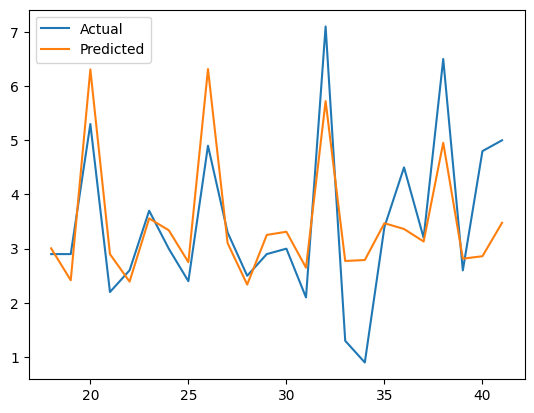

In [4]:
import statsmodels.api as sm
from tabulate import tabulate
from scipy.stats import f, t

print(df.columns)
locations_to_keep = ['Nagole','Peerjadiguda','Pratapasingaram','Pillaipalli']
df_filtered = df[df['Location'].isin(locations_to_keep)]
X = df_filtered[['Conductivity', 'Boron','Ammonia','pH']]
y = df_filtered['SAR']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
# plot line chart of predicted vs actual
y_pred = model.predict(X)
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

nagole_group_SAR = df[df['Location'] == 'Nagole']['SAR']
peerjadiguda_group_SAR = df[df['Location'] == 'Peerjadiguda']['SAR']
pratapasingaram_group_SAR = df[df['Location'] == 'Pratapasingaram']['SAR']
pillaipalli_group_SAR = df[df['Location'] == 'Pillaipalli']['SAR']
from scipy.stats import f
k = 4
N = len(nagole_group_SAR) + len(peerjadiguda_group_SAR) + len(pratapasingaram_group_SAR) + len(pillaipalli_group_SAR)
group_means = [np.mean(nagole_group_SAR), np.mean(peerjadiguda_group_SAR), np.mean(pratapasingaram_group_SAR), np.mean(pillaipalli_group_SAR)]
grand_mean = np.mean([np.mean(nagole_group_SAR), np.mean(peerjadiguda_group_SAR), np.mean(pratapasingaram_group_SAR), np.mean(pillaipalli_group_SAR)])
SSb = sum([len(nagole_group_SAR) * (group_means[0] - grand_mean) ** 2,
           len(peerjadiguda_group_SAR) * (group_means[1] - grand_mean) ** 2,
           len(pratapasingaram_group_SAR) * (group_means[2] - grand_mean) ** 2,
           len(pillaipalli_group_SAR) * (group_means[3] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([nagole_group_SAR, peerjadiguda_group_SAR, pratapasingaram_group_SAR, pillaipalli_group_SAR]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)

### ANOVA

In [5]:
# Generate ANOVA tables
anova_table_variation = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

anova_table_f = [
    ["Between Groups", f"{F_value:.6f}",f"{p_value:.6f}" ,f"{F_crit:.6f}"],
    ["Within Groups"],
    ["Total"]
]

print("ANOVA Table (Variation)")
print(tabulate(anova_table_variation, headers=["Source of Variation", "SS", "df", "MS"], tablefmt="pretty"))
print("\nANOVA Table (F-Value)")
print(tabulate(anova_table_f, headers=["Source of Variation", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table (Variation)
+---------------------+-----------+----+----------+
| Source of Variation |    SS     | df |    MS    |
+---------------------+-----------+----+----------+
|   Between Groups    | 7.885000  | 3  | 2.628333 |
|    Within Groups    | 45.013333 | 20 | 2.250667 |
|        Total        | 52.898333 | 23 |          |
+---------------------+-----------+----+----------+

ANOVA Table (F-Value)
+---------------------+----------+----------+----------+
| Source of Variation |    F     | p-value  |  F crit  |
+---------------------+----------+----------+----------+
|   Between Groups    | 1.167802 | 0.346774 | 3.098391 |
|    Within Groups    |          |          |          |
|        Total        |          |          |          |
+---------------------+----------+----------+----------+


### F-Test Results

In [6]:
t_stats = model.tvalues
t_critical_5 = t.ppf(1 - 0.05 / 2, model.df_resid)
t_critical_10 = t.ppf(1 - 0.10 / 2, model.df_resid)

# Create table data
t_test_results = [
    ["Constant", t_stats['const'], '-', '-'],
    ["EC", t_stats['Conductivity'], t_critical_5, t_critical_10],
    ["B", t_stats['Boron'], t_critical_5, t_critical_10],
    ["NH3", t_stats['Ammonia'], t_critical_5, t_critical_10],
    ["pH", t_stats['pH'], t_critical_5, t_critical_10]
]

# Print Table 2(a) F-Test Results of MLR to predict SAR
print("Table 2(a) F-Test Results of MLR to predict SAR")
print("The F observed value of {:.3f} is greater than the F critical values of {:.3f} and {:.3f} at a 5% level of significance and at a 10% level of significance respectively. Hence, the dependent variable Sodium adsorption ratio (SAR) is significantly related to the independent variables of Electrical conductivity (EC), Boron (B), Free Ammonia (NH3), and Potential of Hydrogen (pH) at a 5% level of significance.".format(F_value, F_crit, f.ppf(1 - 0.10, dfb, dfw)))

# Print Table 2(b) t-Test Results of MLR to predict SAR
print("\nTable 2(b) t-Test Results of MLR to predict SAR")
print(tabulate(t_test_results, headers=["Independent Variables", "t-statistic observed", "t-critical at 5%", "t-critical at 10%"], tablefmt="pretty"))

Table 2(a) F-Test Results of MLR to predict SAR
The F observed value of 1.168 is greater than the F critical values of 3.098 and 2.380 at a 5% level of significance and at a 10% level of significance respectively. Hence, the dependent variable Sodium adsorption ratio (SAR) is significantly related to the independent variables of Electrical conductivity (EC), Boron (B), Free Ammonia (NH3), and Potential of Hydrogen (pH) at a 5% level of significance.

Table 2(b) t-Test Results of MLR to predict SAR
+-----------------------+----------------------+-------------------+--------------------+
| Independent Variables | t-statistic observed | t-critical at 5%  | t-critical at 10%  |
+-----------------------+----------------------+-------------------+--------------------+
|       Constant        |  0.710312840683833   |         -         |         -          |
|          EC           |  1.087654306048369   | 2.093024054408263 | 1.7291328115213673 |
|           B           |  3.9289013482464226  

## Predicting Conductivity using SAR, pH, Ammonia, Boron as Independent Variables

### OLS Regression

                            OLS Regression Results                            
Dep. Variable:           Conductivity   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     6.091
Date:                Thu, 25 Apr 2024   Prob (F-statistic):            0.00279
Time:                        18:29:59   Log-Likelihood:                -208.36
No. Observations:                  30   AIC:                             424.7
Df Residuals:                      26   BIC:                             430.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        227.1930   1277.347      0.178      0.8

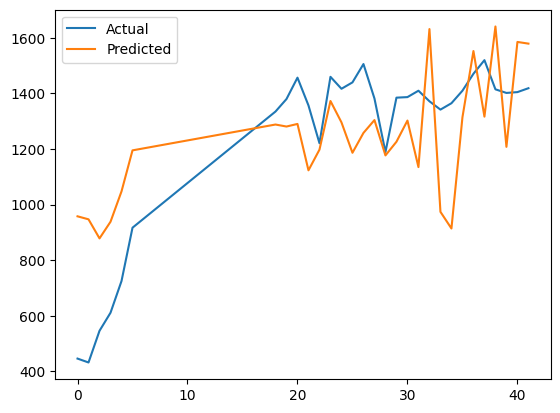

In [7]:
locations_to_keep = ['Nagole','Peerjadiguda','Pratapasingaram','Pillaipalli','Gandipet']
df_filtered = df[df['Location'].isin(locations_to_keep)]
X = df_filtered[['SAR', 'Boron','pH']]
y = df_filtered['Conductivity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
# plot line chart of predicted vs actual
y_pred = model.predict(X)
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### ANOVA

In [8]:
nagole_group_Conductivity = df[df['Location'] == 'Nagole']['Conductivity']
peerjadiguda_group_Conductivity = df[df['Location'] == 'Peerjadiguda']['Conductivity']
pratapasingaram_group_Conductivity = df[df['Location'] == 'Pratapasingaram']['Conductivity']
pillaipalli_group_Conductivity = df[df['Location'] == 'Pillaipalli']['Conductivity']

k = 4
N = len(nagole_group_Conductivity) + len(peerjadiguda_group_Conductivity) + len(pratapasingaram_group_Conductivity) + len(pillaipalli_group_Conductivity)
group_means = [np.mean(nagole_group_Conductivity), np.mean(peerjadiguda_group_Conductivity), np.mean(pratapasingaram_group_Conductivity), np.mean(pillaipalli_group_Conductivity)]
grand_mean = np.mean([np.mean(nagole_group_Conductivity), np.mean(peerjadiguda_group_Conductivity), np.mean(pratapasingaram_group_Conductivity), np.mean(pillaipalli_group_Conductivity)])
SSb = sum([len(nagole_group_Conductivity) * (group_means[0] - grand_mean) ** 2,
           len(peerjadiguda_group_Conductivity) * (group_means[1] - grand_mean) ** 2,
           len(pratapasingaram_group_Conductivity) * (group_means[2] - grand_mean) ** 2,
           len(pillaipalli_group_Conductivity) * (group_means[3] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([nagole_group_Conductivity, peerjadiguda_group_Conductivity, pratapasingaram_group_Conductivity, pillaipalli_group_Conductivity]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)

# Generate ANOVA tables
anova_table_variation = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

anova_table_f = [
    ["Between Groups", f"{F_value:.6f}",f"{p_value:.6f}" ,f"{F_crit:.6f}"],
    ["Within Groups"],
    ["Total"]
]

# Print ANOVA tables
print("ANOVA Table (Variation)")
print(tabulate(anova_table_variation, headers=["Source of Variation", "SS", "df", "MS"], tablefmt="pretty"))
print("\nANOVA Table (F-Value)")
print(tabulate(anova_table_f, headers=["Source of Variation", "F", "p-value","F crit"], tablefmt="pretty"))


ANOVA Table (Variation)
+---------------------+---------------+----+-------------+
| Source of Variation |      SS       | df |     MS      |
+---------------------+---------------+----+-------------+
|   Between Groups    | 17271.458333  | 3  | 5757.152778 |
|    Within Groups    | 111110.166667 | 20 | 5555.508333 |
|        Total        | 128381.625000 | 23 |             |
+---------------------+---------------+----+-------------+

ANOVA Table (F-Value)
+---------------------+----------+----------+----------+
| Source of Variation |    F     | p-value  |  F crit  |
+---------------------+----------+----------+----------+
|   Between Groups    | 1.036296 | 0.397895 | 3.098391 |
|    Within Groups    |          |          |          |
|        Total        |          |          |          |
+---------------------+----------+----------+----------+


### F-Test Results

In [9]:
print("F-Test Results of MLR to predict EC")
print("\nF observed value: {:.2f}".format(F_value))
print("F critical values at 5% and 10% level of significance: {:.3f}, {:.3f}".format(F_crit, f.ppf(1 - 0.10, dfb, dfw)))
print("\nThe F observed value of {:.2f} is greater than F critical values of {:.3f} and {:.3f} at a 5% level of significance and at a 10 % level of significance respectively. Hence, the dependent variable electrical conductivity (EC) is significantly related to the independent variables of potential of hydrogen (pH), sodium adsorption ratio (SAR) and Boron (B) at a 5% level of significance.".format(F_value, F_crit, f.ppf(1 - 0.10, dfb, dfw)))

# Calculate t-test
t_stats = model.tvalues
t_critical_5 = t.ppf(1 - 0.05 / 2, model.df_resid)
t_critical_10 = t.ppf(1 - 0.10 / 2, model.df_resid)

# Print t-test results
print("\nTable 4(b) t-Test Results of MLR to predict EC")
t_test_results = [
    ["Constant", t_stats['const'], '-', '-'],
    ["pH", t_stats['pH'], t_critical_5, t_critical_10],
    ["SAR", t_stats['SAR'], t_critical_5, t_critical_10],
    ["Boron", t_stats['Boron'], t_critical_5, t_critical_10]
]
print(tabulate(t_test_results, headers=["Independent Variables", "t-statistic observed", "t-critical at 5%", "t-critical at 10%"], tablefmt="pretty"))

F-Test Results of MLR to predict EC

F observed value: 1.04
F critical values at 5% and 10% level of significance: 3.098, 2.380

The F observed value of 1.04 is greater than F critical values of 3.098 and 2.380 at a 5% level of significance and at a 10 % level of significance respectively. Hence, the dependent variable electrical conductivity (EC) is significantly related to the independent variables of potential of hydrogen (pH), sodium adsorption ratio (SAR) and Boron (B) at a 5% level of significance.

Table 4(b) t-Test Results of MLR to predict EC
+-----------------------+----------------------+-------------------+--------------------+
| Independent Variables | t-statistic observed | t-critical at 5%  | t-critical at 10%  |
+-----------------------+----------------------+-------------------+--------------------+
|       Constant        | 0.17786312558187295  |         -         |         -          |
|          pH           | 0.43607639738521786  | 2.055529438642871 | 1.70561791975

## Predicitng BOD using SAR, DO, pH as Independent Variables

### OLS Regression

In [10]:
locations_to_keep = ['Nagole','Peerjadiguda','Pratapasingaram','Pillaipalli']
df_filtered = df[df['Location'].isin(locations_to_keep)]
X = df_filtered[['SAR', 'DO','pH']]
y = df_filtered['BOD']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
# plot line chart of predicted vs actual
y_pred = model.predict(X)
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    BOD   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     2.936
Date:                Thu, 25 Apr 2024   Prob (F-statistic):             0.0583
Time:                        18:29:59   Log-Likelihood:                -79.813
No. Observations:                  24   AIC:                             167.6
Df Residuals:                      20   BIC:                             172.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1025     43.554     -0.025      0.9

### ANOVA

In [11]:
nagole_group_BOD = df[df['Location'] == 'Nagole']['BOD']
peerjadiguda_group_BOD = df[df['Location'] == 'Peerjadiguda']['BOD']
pratapasingaram_group_BOD = df[df['Location'] == 'Pratapasingaram']['BOD']
pillaipalli_group_BOD = df[df['Location'] == 'Pillaipalli']['BOD']
k = 4
N = len(nagole_group_BOD) + len(peerjadiguda_group_BOD) + len(pratapasingaram_group_BOD) + len(pillaipalli_group_BOD)
group_means = [np.mean(nagole_group_BOD), np.mean(peerjadiguda_group_BOD), np.mean(pratapasingaram_group_BOD), np.mean(pillaipalli_group_BOD)]
grand_mean = np.mean([np.mean(nagole_group_BOD), np.mean(peerjadiguda_group_BOD), np.mean(pratapasingaram_group_BOD), np.mean(pillaipalli_group_BOD)])
SSb = sum([len(nagole_group_BOD) * (group_means[0] - grand_mean) ** 2,
           len(peerjadiguda_group_BOD) * (group_means[1] - grand_mean) ** 2,
           len(pratapasingaram_group_BOD) * (group_means[2] - grand_mean) ** 2,
           len(pillaipalli_group_BOD) * (group_means[3] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([nagole_group_BOD, peerjadiguda_group_BOD, pratapasingaram_group_BOD, pillaipalli_group_BOD]) for x in data])
dfw = N-k 
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)
# Generate ANOVA tables
anova_table_variation = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

anova_table_f = [
    ["Between Groups", f"{F_value:.6f}",f"{p_value:.6f}" ,f"{F_crit:.6f}"],
    ["Within Groups"],
    ["Total"]
]

# Print ANOVA tables
print("ANOVA Table (Variation)")
print(tabulate(anova_table_variation, headers=["Source of Variation", "SS", "df", "MS"], tablefmt="pretty"))
print("\nANOVA Table (F-Value)")
print(tabulate(anova_table_f, headers=["Source of Variation", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table (Variation)
+---------------------+-------------+----+------------+
| Source of Variation |     SS      | df |     MS     |
+---------------------+-------------+----+------------+
|   Between Groups    | 745.500000  | 3  | 248.500000 |
|    Within Groups    | 820.333333  | 20 | 41.016667  |
|        Total        | 1565.833333 | 23 |            |
+---------------------+-------------+----+------------+

ANOVA Table (F-Value)
+---------------------+----------+----------+----------+
| Source of Variation |    F     | p-value  |  F crit  |
+---------------------+----------+----------+----------+
|   Between Groups    | 6.058513 | 0.004167 | 3.098391 |
|    Within Groups    |          |          |          |
|        Total        |          |          |          |
+---------------------+----------+----------+----------+


### F-Test Results

In [12]:
print("F-Test Results of MLR to predict BOD")
print()
print("df", dfb)
print("Residual df", dfw)
print("F observed", F_value)
print("F critical at 5% level of significance", F_crit)
print("F critical at 10% level of significance", f.ppf(1 - 0.10, dfb, dfw))

print("\nFobserved value of {:.3f} is greater than Fcritical values {:.3f} and {:.3f} at 5% level of significance and at 5% level of significance respectively. Hence, the dependent variable Biological oxygen demand (BOD) is significantly related to the independent variables of potential of Hydrogen (pH), Dissolved oxygen (DO), and Sodium adsorption ratio (SAR) at 5% level of significance.".format(F_value, F_crit, f.ppf(1 - 0.10, dfb, dfw)))

# Calculate t-test
t_stats = model.tvalues
t_critical_5 = t.ppf(1 - 0.05 / 2, model.df_resid)
t_critical_10 = t.ppf(1 - 0.10 / 2, model.df_resid)
t_critical_20 = t.ppf(1 - 0.20 / 2, model.df_resid)
t_critical_25 = t.ppf(1 - 0.25 / 2, model.df_resid)
t_critical_30 = t.ppf(1 - 0.30 / 2, model.df_resid)
t_critical_40 = t.ppf(1 - 0.40 / 2, model.df_resid)
t_critical_45 = t.ppf(1 - 0.45 / 2, model.df_resid)

# Print t-test results
print("\nTable 6(b) t-Test Results of MLR to predict BOD")
t_test_results = [
    ["Constant", '-', '-', '-', '-', '-', '-', '-', '-'],
    ["pH", t_stats['pH'], t_critical_5, t_critical_10, t_critical_20, t_critical_25, t_critical_30, t_critical_40, t_critical_45],
    ["DO", t_stats['DO'], t_critical_5, t_critical_10, t_critical_20, t_critical_25, t_critical_30, t_critical_40, t_critical_45],
    ["SAR", t_stats['SAR'], t_critical_5, t_critical_10, t_critical_20, t_critical_25, t_critical_30, t_critical_40, t_critical_45]
]
print(tabulate(t_test_results, headers=["S. No.", "Independent Variables", "t-observed", "t-critical at 5%", "t-critical at 10%", "t-critical at 20%", "t-critical at 25%", "t-critical at 30%", "t-critical at 40%", "t-critical at 45%"], tablefmt="pretty"))


F-Test Results of MLR to predict BOD

df 3
Residual df 20
F observed 6.058512799674931
F critical at 5% level of significance 3.09839121214078
F critical at 10% level of significance 2.3800870510696073

Fobserved value of 6.059 is greater than Fcritical values 3.098 and 2.380 at 5% level of significance and at 5% level of significance respectively. Hence, the dependent variable Biological oxygen demand (BOD) is significantly related to the independent variables of potential of Hydrogen (pH), Dissolved oxygen (DO), and Sodium adsorption ratio (SAR) at 5% level of significance.

Table 6(b) t-Test Results of MLR to predict BOD
+----------+-----------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  S. No.  | Independent Variables |    t-observed     |  t-critical at 5%  | t-critical at 10%  | t-critical at 20%  | t-critical at 25%  | t-critical at 30%  | t-critical at 40%  |
+-

## Predicting DO using BOD, pH as Independent Variables

### OLS Regression

                            OLS Regression Results                            
Dep. Variable:                     DO   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     4.301
Date:                Thu, 25 Apr 2024   Prob (F-statistic):             0.0272
Time:                        18:29:59   Log-Likelihood:                -24.373
No. Observations:                  24   AIC:                             54.75
Df Residuals:                      21   BIC:                             58.28
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4957      3.858      0.906      0.3

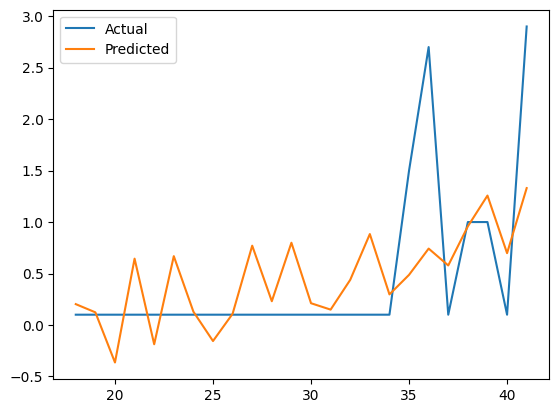

In [13]:
locations_to_keep = ['Nagole','Peerjadiguda','Pratapasingaram','Pillaipalli']
df_filtered = df[df['Location'].isin(locations_to_keep)]
X = df_filtered[['pH','BOD']]
y = df_filtered['DO']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
# plot line chart of predicted vs actual
y_pred = model.predict(X)
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### ANOVA

In [14]:
nagole_group_DO = df[df['Location'] == 'Nagole']['DO']
peerjadiguda_group_DO = df[df['Location'] == 'Peerjadiguda']['DO']
pratapasingaram_group_DO = df[df['Location'] == 'Pratapasingaram']['DO']
pillaipalli_group_DO = df[df['Location'] == 'Pillaipalli']['DO']

k = 4
N = len(nagole_group_DO) + len(peerjadiguda_group_DO) + len(pratapasingaram_group_DO) + len(pillaipalli_group_DO)
group_means = [np.mean(nagole_group_DO), np.mean(peerjadiguda_group_DO), np.mean(pratapasingaram_group_DO), np.mean(pillaipalli_group_DO)]
grand_mean = np.mean([np.mean(nagole_group_DO), np.mean(peerjadiguda_group_DO), np.mean(pratapasingaram_group_DO), np.mean(pillaipalli_group_DO)])
SSb = sum([len(nagole_group_DO) * (group_means[0] - grand_mean) ** 2,
           len(peerjadiguda_group_DO) * (group_means[1] - grand_mean) ** 2,
           len(pratapasingaram_group_DO) * (group_means[2] - grand_mean) ** 2,
           len(pillaipalli_group_DO) * (group_means[3] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([nagole_group_DO, peerjadiguda_group_DO, pratapasingaram_group_DO, pillaipalli_group_DO]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)

# Generate ANOVA tables
anova_table_variation = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

anova_table_f = [
    ["Between Groups", f"{F_value:.6f}",f"{p_value:.6f}" ,f"{F_crit:.6f}"],
    ["Within Groups"],
    ["Total"]
]

# Print ANOVA tables
print("ANOVA Table (Variation)")
print(tabulate(anova_table_variation, headers=["Source of Variation", "SS", "df", "MS"], tablefmt="pretty"))
print("\nANOVA Table (F-Value)")
print(tabulate(anova_table_f, headers=["Source of Variation", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table (Variation)
+---------------------+-----------+----+----------+
| Source of Variation |    SS     | df |    MS    |
+---------------------+-----------+----+----------+
|   Between Groups    | 5.885000  | 3  | 1.961667 |
|    Within Groups    | 9.213333  | 20 | 0.460667 |
|        Total        | 15.098333 | 23 |          |
+---------------------+-----------+----+----------+

ANOVA Table (F-Value)
+---------------------+----------+----------+----------+
| Source of Variation |    F     | p-value  |  F crit  |
+---------------------+----------+----------+----------+
|   Between Groups    | 4.258321 | 0.017650 | 3.098391 |
|    Within Groups    |          |          |          |
|        Total        |          |          |          |
+---------------------+----------+----------+----------+


### F-Test Results

In [15]:
# Your code here
print("F-Test Results of MLR to predict DO")
print("Regression")
print("df", dfb)
print("Residual df", dfw)
print("Fobserved", F_value)
print("F critical at 5% level of significance", F_crit)
print("F critical at 10% level of significance", f.ppf(1 - 0.10, dfb, dfw))

print("\nThe F observed value of {:.3f} is greater than F critical values of {:.3f} and {:.3f} at a 5% level of significance and at a 10% level of significance respectively. Hence, the dependent variable Dissolved oxygen (DO) is significantly related to the independent variables of potential of Hydrogen (pH) and Biological oxygen demand (BOD) at a 5% level of significance.".format(F_value, F_crit, f.ppf(1 - 0.10, dfb, dfw)))

# Calculate t-test
t_stats = model.tvalues
t_critical_5 = t.ppf(1 - 0.05 / 2, model.df_resid)
t_critical_10 = t.ppf(1 - 0.10 / 2, model.df_resid)
t_critical_20 = t.ppf(1 - 0.20 / 2, model.df_resid)
t_critical_25 = t.ppf(1 - 0.25 / 2, model.df_resid)
t_critical_30 = t.ppf(1 - 0.30 / 2, model.df_resid)
t_critical_40 = t.ppf(1 - 0.40 / 2, model.df_resid)
t_critical_45 = t.ppf(1 - 0.45 / 2, model.df_resid)

# Print t-test results
print("\nTable 8(b) t-Test Results of MLR to predict DO")
t_test_results = [
    ["pH", t_stats['pH'], t_critical_5, t_critical_10, t_critical_20, t_critical_25, t_critical_30, t_critical_40, t_critical_45],
    ["BOD", t_stats['BOD'], t_critical_5, t_critical_10, t_critical_20, t_critical_25, t_critical_30, t_critical_40, t_critical_45]
]
print(tabulate(t_test_results, headers=["S. No.", "Independent Variables", "t-observed", "t-critical at 5%", "t-critical at 10%", "t-critical at 20%", "t-critical at 25%", "t-critical at 30%", "t-critical at 40%", "t-critical at 45%"], tablefmt="pretty"))


F-Test Results of MLR to predict DO
Regression
df 3
Residual df 20
Fobserved 4.2583212735166445
F critical at 5% level of significance 3.09839121214078
F critical at 10% level of significance 2.3800870510696073

The F observed value of 4.258 is greater than F critical values of 3.098 and 2.380 at a 5% level of significance and at a 10% level of significance respectively. Hence, the dependent variable Dissolved oxygen (DO) is significantly related to the independent variables of potential of Hydrogen (pH) and Biological oxygen demand (BOD) at a 5% level of significance.

Table 8(b) t-Test Results of MLR to predict DO
+--------+-----------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| S. No. | Independent Variables |    t-observed     |  t-critical at 5%  | t-critical at 10%  | t-critical at 20%  | t-critical at 25%  | t-critical at 30%  | t-critical at 40%  |
+--------+----